In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import plotly.graph_objects as go
%matplotlib inline

In [88]:
metadata = pd.read_csv('metadata.csv')
train_labels = pd.read_csv('train_labels.csv')
metadata.head()

,sample_id,split,derivatized,features_path,features_md5_hash
0,S0000,train,NaN,train_features/S0000.csv,52ec6d6f8372500ab4e069b5fbdae6f9
1,S0001,train,NaN,train_features/S0001.csv,348f90baed8a8189bf0d4c7b9ed9f965
2,S0002,train,1.0,train_features/S0002.csv,4686ad9bc3716966f63b6ff83d1d8324
3,S0003,train,NaN,train_features/S0003.csv,de6b53605c5887967dc3661a3a711c2b
4,S0004,train,NaN,train_features/S0004.csv,fbfd90092d10d15a5d6919327ddde2ab


In [89]:
def metadata_parser(metadata):
    train_dict = {}
    val_dict = {}
    for row in metadata.iterrows():
        if row[1].split == 'train':
            train_dict[row[1].sample_id] = row[1].features_path
        else:
            val_dict[row[1].sample_id] = row[1].features_path
    return train_dict, val_dict

def train_label_parser(train_labels):
    train_labels_dict = {}
    for row in train_labels.iterrows():
        row_list = list(row[1])
        train_labels_dict[row_list[0]] = row_list[1:]
    columns = list(train_labels.columns)
    return train_labels_dict, columns[1:]

train_path, val_path = metadata_parser(metadata)
train_labels_dict, labels = train_label_parser(train_labels)

def get_ids_per_class():
    ids_per_class = {}
    for class_name in labels:
        index = labels.index(class_name)
        ids = []
        for key, value in train_labels_dict.items():
            if value[index] == 1:
                ids.append(key)
        ids_per_class[class_name] = ids
    return ids_per_class
    
ids_per_class = get_ids_per_class()
labels

['aromatic',
 'hydrocarbon',
 'carboxylic_acid',
 'nitrogen_bearing_compound',
 'chlorine_bearing_compound',
 'sulfur_bearing_compound',
 'alcohol',
 'other_oxygen_bearing_compound',
 'mineral']

In [114]:
def train_data_parser(id):
    path = train_path[id]
    data = pd.read_csv(path)
    data.sort_values('mass')
    labels = list(data.columns)
    data = {
        'time': np.array(data.time),
        'mass': np.array(data.mass),
        'intensity': np.array(data.intensity),
    }
    return data


def peak_intensity_plotter(sample_id, number_of_peaks, width):
    data = train_data_parser(sample_id)
    indices = find_peaks(data['intensity'], width=width)[0]
    sorted_peaks = sorted(indices, key=lambda x: data['intensity'][x], reverse=True)
    filtered_indices = sorted_peaks[:number_of_peaks]
    plt.plot(data['mass'], data['intensity'])
    plt.plot(data['mass'][filtered_indices], 
             data['intensity'][filtered_indices], 
             'x', color='red')
    return indices

array([   203,    575,   1820,   2245,   2419,   2698,   3523,   4790,
         5208,   5343,   5492,   5625,   5637,   6057,   7336,   7807,
         7974,   8615,   8690,   9405,   9849,  10753,  11061,  11734,
        11916,  11956,  12422,  12554,  12770,  12855,  13004,  13153,
        13434,  13565,  13646,  14406,  14436,  15790,  16204,  16924,
        17063,  17164,  17716,  17770,  17804,  17871,  18592,  19003,
        19850,  20303,  20358,  21650,  22559,  22832,  23311,  24361,
        24664,  24896,  25067,  26658,  26993,  27482,  27901,  27981,
        29162,  30080,  30098,  30200,  30347,  30442,  30764,  31348,
        31600,  32262,  33408,  33879,  34141,  34223,  34566,  34724,
        35397,  35546,  35910,  36460,  37545,  38059,  38396,  38760,
        38905,  40600,  40863,  41132,  41431,  41694,  41709,  42542,
        43548,  45212,  47318,  47574,  47822,  48077,  48139,  48385,
        48878,  49392,  50234,  52823,  54065,  56148,  56327,  57112,
      

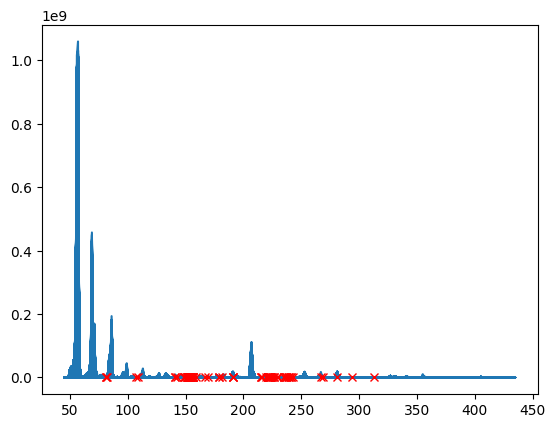

In [115]:
peak_intensity_plotter(ids_per_class['hydrocarbon'][4], 100, 5)